#  Optimization Guide to Battery Scheduling with Gurobi

This notebook provides a beginner-friendly introduction to battery scheduling using mathematical optimization and Gurobi. Basic knowledge about mathematical optimization and Python programming are required as taught in [Optimization 101 for Data Scientists](https://www.gurobi.com/events/optimization-101-for-data-scientists/) as well as the basics in battery energy management. The notebook is structured as follows: 
- First we introduce the battery scheduling problem in 3 different variants with increasing complexity.
- Second we define example parameters for 3 days of battery operations. 
- Third we build the 3 different model variants in gurobipy.
- Fourth we run the Gurobi Optimizer on a selected model.
- Fifth we visualize the optimized battery operations schedule. 

## 1. Introduction

The battery scheduling problem is about deciding when to charge and discharge a behind-the-meter battery to maximize profit (or minimize cost) given predictions of time-dependent electricity prices (tariffs). In this notebook, we also consider photovoltaic (PV) generation, and technical constraints of the battery.

---

### Load & Generation (LG) Model
We start very simple to set a baseline for the economic costs: Import electricity from the grid to compensate deficits resulting from a higher load than PV generation. Vice versa, export electricity to the grid if PV generates more power than the load is. There is no battery considered yet.

<div style="text-align: center;">
    <img src="Picture1.svg" width="640">

</div>

We are given:
- A discrete time horizon $ \mathcal{T} = \{0, \ldots, T-1\} $ with step size $ \Delta t $ (hours)
- Load $ L_t $ (kW) and PV $ G_t $ (kW) profiles
- Import price $ p^{\mathrm{imp}}_t $ (€/kWh) and export price $ p^{\mathrm{exp}}_t $ (€/kWh)

We decide per time step $ t $:
- Imports $ P^{\mathrm{imp}}_t \ge 0 $, exports $ P^{\mathrm{exp}}_t \ge 0 $ (kW)


We maximize profit:

$$
\max \sum_{t \in \mathcal{T}}
\Delta t \,\big( p^{\mathrm{exp}}_t\, P^{\mathrm{exp}}_t - p^{\mathrm{imp}}_t\, P^{\mathrm{imp}}_t \big)
$$

subject to:
- The overall energy balance:

  $$
  P^{\mathrm{imp}}_t \;-\; P^{\mathrm{exp}}_t \;=\; L_t \;-\; G_t
  \qquad \forall t \in \mathcal{T}
  $$

<i>**Solution:** To get the highest profit possible, we simply import power for deficits (as much as needed) and export for surplusses (as much as possible). No optimization model is needed.</i>

---

### Storage (S) Model

Next, we include the battery. But this time, there is no load & PV system yet. The battery is simply used for price arbitrage given the time-dependent import & export prices in the grid. 

<div style="text-align: center;">
    <img src="Picture2.svg" width="640">
</div>

We are given:
- A discrete time horizon $ \mathcal{T} = \{0, \ldots, T-1\} $ with step size $ \Delta t $ (hours)
- Import price $ p^{\mathrm{imp}}_t $ (€/kWh) and export price $ p^{\mathrm{exp}}_t $ (€/kWh)
- Battery with usable energy capacity $ E_{\max} $ (kWh), charge/discharge power limits $ P^{\mathrm{ch}}_{\max},\, P^{\mathrm{dis}}_{\max} $ (kW), efficiencies $ \eta_{\mathrm{ch}},\, \eta_{\mathrm{dis}} $, and initial state of charge (SoC) $ E_0 $ (kWh)

We decide per time step $ t $:
- Charge power $ x^{\mathrm{ch}}_t \ge 0 $ as imports from the grid, discharge power $ x^{\mathrm{dis}}_t \ge 0 $ (kW) as exports to the grid
- State of charge $ E_t $ (kWh)

We maximize profit:

$$
\max \sum_{t \in \mathcal{T}}
\Delta t \,\big( p^{\mathrm{exp}}_t\, x^{\mathrm{dis}}_t - p^{\mathrm{imp}}_t\, x^{\mathrm{ch}}_t \big)
$$

subject to:

- The battery state-of-charge balance:

  $$
  E_t \;=\; E_{t-1} \;+\; \eta_{\mathrm{ch}}\, x^{\mathrm{ch}}_t \,\Delta t \;-\; \frac{1}{\eta_{\mathrm{dis}}}\, x^{\mathrm{dis}}_t \,\Delta t
  \qquad \forall t \in \mathcal{T}
  $$

- The battery state-of-charge bounds: $ 0 \le E_t \le E_{\max} $

- The battery (dis)charge bounds: $ x^{\mathrm{ch}}_t \le P_{\max} $, $ x^{\mathrm{dis}}_t \le P_{\max} $


<i>**Solution:** To get the highest profit possible, we need an optimization model to decide when and how much to import/export from/to the grid and (dis)charge to the battery.</i>

---

### Load, Generation & Storage (LGS) Model

Next, we connect the battery to the load & PV system and introduce battery degradation costs as an example of non-linear constraints.

<div style="text-align: center;">
    <img src="Picture3.svg" width="640">
</div>

We are given:
- A discrete time horizon $ \mathcal{T} = \{0, \ldots, T-1\} $ with step size $ \Delta t $ (hours)
- Load $ L_t $ (kW) and PV $ G_t $ (kW) profiles
- Import price $ p^{\mathrm{imp}}_t $ (€/kWh) and export price $ p^{\mathrm{exp}}_t $ (€/kWh)
- Battery with usable energy capacity $ E_{\max} $ (kWh), charge/discharge power limits $ P^{\mathrm{ch}}_{\max},\, P^{\mathrm{dis}}_{\max} $ (kW), efficiencies $ \eta_{\mathrm{ch}},\, \eta_{\mathrm{dis}} $, and initial state of charge (SoC) $ E_0 $ (kWh)
- Nonlinear degradation cost parameters:
  - $ \kappa_{\mathrm{cyc}} > 0 $ (€/EFC): cost per equivalent full cycle (one full charge–discharge of $E_{\max}$)
  - $ \beta $: mild power-law exponent describing degradation growth with (normalized) throughput

  We normalize per-step throughput by capacity to obtain the C-flow (fraction of an equivalent full cycle within the step).

We decide per time step $ t $:
- Charge power $ x^{\mathrm{ch}}_t \ge 0 $, discharge power $ x^{\mathrm{dis}}_t \ge 0 $ (kW)
- Imports $ P^{\mathrm{imp}}_t \ge 0 $, exports $ P^{\mathrm{exp}}_t \ge 0 $ (kW)
- State of charge $ E_t $ (kWh)

We maximize profit:

$$
\max \sum_{t \in \mathcal{T}}
\Big[
\Delta t \,\big( p^{\mathrm{exp}}_t\, P^{\mathrm{exp}}_t - p^{\mathrm{imp}}_t\, P^{\mathrm{imp}}_t \big)
\Big]
\;-\;
\sum_{t \in \mathcal{T}} 
\kappa_{\mathrm{cyc}} \,
\bigg(
\underbrace{ 
\Delta t \,\frac{x^{\mathrm{ch}}_t + x^{\mathrm{dis}}_t}{E_{\max}}
}_{c_t\;\text{(C-flow per step)}}
\bigg)^{\beta}
$$

subject to:

- The overall energy balance:

  $$
  P^{\mathrm{imp}}_t \;-\; P^{\mathrm{exp}}_t \;+\; x^{\mathrm{dis}}_t \;-\; x^{\mathrm{ch}}_t
  \;=\; L_t \;-\; G_t
  \qquad \forall t \in \mathcal{T}
  $$
  
- The battery state-of-charge balance:

  $$
  E_t \;=\; E_{t-1} \;+\; \eta_{\mathrm{ch}}\, x^{\mathrm{ch}}_t \,\Delta t \;-\; \frac{1}{\eta_{\mathrm{dis}}}\, x^{\mathrm{dis}}_t \,\Delta t
  \qquad \forall t \in \mathcal{T}
  $$

- The battery state-of-charge bounds: $ 0 \le E_t \le E_{\max} $

- The battery (dis)charge bounds: $ x^{\mathrm{ch}}_t \le P^{\mathrm{ch}}_{\max} $, $ x^{\mathrm{dis}}_t \le P^{\mathrm{dis}}_{\max} $



- Note:
This model incorporates non-linear degradation costs in the objective function. The degradation of the maximum battery capacity $E_{\max}$ could be modeled in the same way leading to a non-linear constrained model.


<i>**Solution:** To get the highest profit possible, we need an optimization model to decide when and how much to import/export from/to the grid and (dis)charge to the battery given load & PV power generation as well as battery wearout.</i>


## 2. Model Parameters

We define a set of realistic model parameters for a 24 hours cycle (this design can be altered).


In [15]:
# Import all necessary packages
import math
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import GRB

# === INSTANCE CONFIGURATION ===

# Horizon
T = 24 
dt_h = 1.0  # hours per step

# Tariff and cost parameters
beta = 1.5                # power-law exponent for nonlinear degradation
kappa_cyc = 1              # €/EFC (cost per equivalent full cycle)

# Battery
E_max_kwh = 13.5
P_ch_max_kw = 5.0
P_dis_max_kw = 5.0
eta_ch = 0.96
eta_dis = 0.96
SoC0_kwh = 6.0
SoC_terminal = 6.0  

In [16]:
# === INSTANCE GENERATION ===
def default_24h_profiles():
    load_24 = [2.4,2.4,2.3,2.2,2.1,2.0, 1.6,1.6,1.7,1.8,2.0,2.2,
               2.3,2.4,2.5,2.4,2.2,2.0, 2.1,2.3,2.6,2.8,2.8,2.6]
    pv_24   = [0.0,0.0,0.0,0.0,0.0,0.0, 0.2,0.5,1.0,2.0,3.2,3.8,
               4.0,4.2,3.6,2.8,1.8,0.8, 0.2,0.1,0.0,0.0,0.0,0.0]
    imp_24  = [0.16,0.15,0.14,0.14,0.15,0.17, 0.18,0.17,0.16,0.16,0.15,0.15,
               0.16,0.18,0.20,0.22,0.24,0.26, 0.30,0.34,0.38,0.40,0.38,0.34]
    exp_24  = [0.1,0.1,0.1,0.1,0.1,0.1, 0.1,0.1,0.1,0.1,0.1,0.1,
               0.14,0.16,0.18,0.20,0.22,0.24, 0.29,0.3,0.3,0.4,0.3,0.3]
    return load_24, pv_24, imp_24, exp_24

load, pv, imp, exp = default_24h_profiles()

# Quick glance at the first day
df_preview = pd.DataFrame({
    "t": list(range(24)),
    "load_kW": load[:24],
    "pv_kW": pv[:24],
    "import €/kWh": imp[:24],
    "export €/kWh": exp[:24]
})
df_preview.head(24)


,t,load_kW,pv_kW,import €/kWh,export €/kWh
0,0,2.4,0.0,0.16,0.10
1,1,2.4,0.0,0.15,0.10
2,2,2.3,0.0,0.14,0.10
3,3,2.2,0.0,0.14,0.10
4,4,2.1,0.0,0.15,0.10
5,5,2.0,0.0,0.17,0.10
6,6,1.6,0.2,0.18,0.10
7,7,1.6,0.5,0.17,0.10
8,8,1.7,1.0,0.16,0.10
9,9,1.8,2.0,0.16,0.10


## 3. Models 

Next, we build the 3 models with increasing complexity. For the first model, we don't need the Gurobi Optimizer yet. For the second and third model, we use the [gurobipy](https://www.gurobi.com/faqs/gurobipy/) package.

- **Load & Generation (LG)**: Use imports/exports to balance deficits/surpluses resulting from load/PV without battery.
- **Storage (S)**: Use battery for price arbitrage (no load/no PV).  
- **Load, Generation & Storage (LGS)**: Use battery behind-the-meter (BTM) for price arbitrage, with load/PV, and battery degradation costs.  

In [17]:
# For the load & generation (LG) model, the profit is simply caluclated by the net energy demand/surplus in each time step multiplied by the import/export price.

def build_lg(load_kw, pv_kw, import_price, export_price, dt_h):
    # Setup the time and import/export profiles
    T = len(load_kw)
    P_imp0, P_exp0 = [], []
    # Compute import/export costs for each time step
    for t in range(T):
        net = load_kw[t] - pv_kw[t]  # calculate power deficit/surplus 
        P_imp0.append(max(0.0, net)); P_exp0.append(max(0.0, -net))
    # Compute profit by cumulating import/export costs across all time steps
    profit = 0.0
    for t in range(T):
        imp_cost = import_price[t] * P_imp0[t] * dt_h
        exp_rev  = export_price[t] * P_exp0[t] * dt_h
        profit += (exp_rev - imp_cost)
                    
    return profit, P_imp0, P_exp0

In [18]:
# For storage (S) model, we need an optimization model. We start by importing the gurobipy package.
import gurobipy as gp
from gurobipy import GRB   # GRB holds Gurobi constants such as GRB.MAXIMIZE

def build_s(T, dt_h, import_price, export_price,
                        E_max_kwh, Pmax_kw, eta_ch, eta_dis, SoC0_kwh,
                        SoC_terminal=None):
    # -----------------------------
    # 1. Create the optimization model
    # -----------------------------
    # gp.Model() creates an empty optimization model in Gurobi.
    # The string "s_model" is just a name to identify the model.
    m = gp.Model("s_model")

    # -----------------------------
    # 2. Set basic solver parameters
    # -----------------------------
    # Gurobi has many parameters that control how the solver runs.
    # We access them via 'm.Params.<ParameterName>'.
    # OutputFlag:
    #   1  -> print solver log to the console
    #   0  -> run silently (no log)
    m.Params.OutputFlag = 1
    # TimeLimit:
    #   Maximum solve time in seconds.
    #   Either the solution is already optimal in less than 10 seconds, or Gurobi hits the time limit, and then returns a usually sub-optimal solution.
    m.Params.TimeLimit = 10

    # -----------------------------
    # 3. Create decision variables
    # -----------------------------
    # We first define a Python index set for the time steps 0, 1, ..., T-1.
    rng = range(T)

    # Now we add variables to the model using m.addVars().
    # addVars(index_set, lb=..., ub=..., name=...) creates a set of variables at once, in our case indexed by time t.
    #   - lb: lower bounds are the minimum values that these variables can take; here same minimum (0) for all variables in the set
    #   - ub: upper bound are the maximum values that these variables can take; here same maximum (Pmax_kw or E_max_kwh) for all variables in the set
    #   - name: base name for variables (Gurobi will generate x_ch[0], x_ch[1], ...)

    # Charging power at each time step (kW), bounded between 0 and Pmax_kw
    x_ch = m.addVars(rng, lb=0.0, ub=Pmax_kw, name="x_ch")

    # Discharging power at each time step (kW), also between 0 and Pmax_kw
    x_dis = m.addVars(rng, lb=0.0, ub=Pmax_kw, name="x_dis")

    # State of charge (SoC) at each time step (kWh), between 0 and E_max_kwh
    SoC = m.addVars(rng, lb=0.0, ub=E_max_kwh, name="SoC")

    # -----------------------------
    # 4. Create constraints: Battery SoC balance
    # -----------------------------
    # Now we add constraints to describe how the SoC evolves over time.
    #
    # For each time t:
    #   inflow  = energy charged into the battery  (kWh)
    #   outflow = energy discharged from the battery (kWh)  

    for t in rng:
        inflow  = eta_ch * x_ch[t] * dt_h          # charge * efficiency * hours
        outflow = (1.0 / eta_dis) * x_dis[t] * dt_h  # discharge / efficiency * hours
        # The SoC balance is SoC[t] = SoC[t-1] + inflow - outflow.
        # At t = 0, we use the given initial SoC (SoC0_kwh).
        if t == 0:
            # First time step: link SoC[0] to initial SoC
            m.addConstr(SoC[t] == SoC0_kwh + inflow - outflow, name=f"soc_balance_{t}")
        else:
            # Subsequent time steps: link SoC[t] to SoC[t-1]
            m.addConstr(SoC[t] == SoC[t-1] + inflow - outflow, name=f"soc_balance_{t}")

    # Optional terminal SoC constraint:
    # If SoC_terminal is provided (not None), enforce that the battery ends with at least this SoC at the final time step.
    if SoC_terminal is not None:
        m.addConstr(SoC[T - 1] >= SoC_terminal, name="terminal_soc")

    # -----------------------------
    # 5. Create objective function: Profit maximization
    # -----------------------------
    # Profit is revenue from discharging minus cost of charging.
    #
    # For each time t:
    #   revenue_t = export_price[t] * x_dis[t] * dt_h
    #   cost_t    = import_price[t] * x_ch[t] * dt_h
    #
    # The total profit is the sum over all t.
    #
    # We use gp.quicksum(...) to efficiently build linear sums in Gurobi.

    profit = gp.quicksum(
        (export_price[t] * x_dis[t] - import_price[t] * x_ch[t]) * dt_h
        for t in rng
    )

    # Next, we tell Gurobi what to optimize and in which direction:
    #   - First argument: the expression to optimize (here: profit)
    #   - Second argument: GRB.MAXIMIZE or GRB.MINIMIZE
    m.setObjective(profit, GRB.MAXIMIZE)

    # At this point, the model is fully defined.
    # We return:
    #   - the model object 'm'
    #   - and a dictionary of the main decision variables for easy access later    
    return m, {"x_ch": x_ch, "x_dis": x_dis, "SoC": SoC}

In [19]:
# For the load, generation & storage model, we need an optimization model that includes not only the battery, but also the grid connection "behind the meter" (BTM).
# We start by importing the gurobipy package.
import gurobipy as gp
from gurobipy import GRB   # GRB holds Gurobi constants such as GRB.MAXIMIZE  

def build_lgs(T, dt_h, load_kw, pv_kw, import_price, export_price,
                    E_max_kwh, P_ch_max_kw, P_dis_max_kw, eta_ch, eta_dis, SoC0_kwh,
                    kappa_cyc, beta, SoC_terminal=None):
    # -----------------------------
    # 1. Create the optimization model
    # -----------------------------
    # gp.Model() creates an empty Gurobi model instance.
    # The string "lgs_model" is just a name used to identify this model.
    m = gp.Model("lgs_model")

    # -----------------------------
    # 2. Set basic solver parameters
    # -----------------------------
    # Gurobi has many parameters that control how the solver runs.
    # We access them via 'm.Params.<ParameterName>'.
    # OutputFlag:
    #   1  -> print solver log to the console
    #   0  -> run silently (no log)
    m.Params.OutputFlag = 1
    # TimeLimit:
    #   Maximum solve time in seconds.
    #   Either the solution is already optimal in less than 10 seconds, or Gurobi hits the time limit, and then returns a usually sub-optimal solution.
    m.Params.TimeLimit = 10

    # -----------------------------
    # 3. Create decision variables
    # -----------------------------
    # We first define an index set for time steps: 0, 1, ..., T-1.
    rng = range(T)

    # Next, we add variables to the model using m.addVars().
    # addVars(index_set, lb=..., ub=..., name=...) creates a set of variables at once, in our case indexed by time t.

    # Charging power of the battery (kW) at each time step, bounded between 0 and P_ch_max_kw.
    x_ch = m.addVars(rng, lb=0.0, ub=P_ch_max_kw, name="x_ch")

    # Discharging power of the battery (kW) at each time step, bounded between 0 and P_dis_max_kw.
    x_dis = m.addVars(rng, lb=0.0, ub=P_dis_max_kw, name="x_dis")

    # State of charge (SoC) of the battery (kWh) at each time step, bounded between 0 and E_max_kwh.
    SoC = m.addVars(rng, lb=0.0, ub=E_max_kwh, name="SoC")

    # Power imported from the grid (kW) at each time step.
    # Lower bound is 0; we do not set an explicit upper bound here as unlimited imports will not be profit-maximizing with import costs > 0.
    P_imp = m.addVars(rng, lb=0.0, name="P_imp")

    # Power exported to the grid (kW) at each time step.
    # Again, nonnegative with no explicit upper bound here as unlimited exports are not possible with battery SoC>=0 and limited PV generation.
    P_exp = m.addVars(rng, lb=0.0, name="P_exp")

    # -----------------------------
    # 4. Create constraints: Battery SoC balance
    # -----------------------------
    # We now describe how the SoC evolves over time.
    #
    # For each time t:
    #   inflow  = energy charged into the battery (kWh)
    #   outflow = energy discharged from the battery (kWh)
    for t in rng:
        inflow  = eta_ch * x_ch[t] * dt_h           # charging energy: power * efficiency * hours
        outflow = (1.0 / eta_dis) * x_dis[t] * dt_h # discharging energy: power / efficiency * hours
     
        # SoC[t] = SoC[t-1] + inflow - outflow
        #
        # For t = 0, we use SoC0_kwh as the initial SoC.
        if t == 0:
            # First time step: link SoC[0] to the given initial SoC.
            m.addConstr(
                SoC[t] == SoC0_kwh + inflow - outflow,
                name=f"soc_balance_{t}"
            )
        else:
            # Subsequent time steps: link SoC[t] to SoC[t-1].
            m.addConstr(
                SoC[t] == SoC[t-1] + inflow - outflow,
                name=f"soc_balance_{t}"
            )

    # -----------------------------
    # 5. Create constraints: Energy balance behind the meter
    # -----------------------------
    # The power balance at each time step t is:
    #
    #   P_imp[t] - P_exp[t] + x_dis[t] - x_ch[t] = load_kw[t] - pv_kw[t]
    #
    # Interpretation:
    #   left-hand side  = net power coming from the grid and battery
    #   right-hand side = net demand (load minus PV generation)
    #
    # If load_kw[t] > pv_kw[t], we need additional power from the grid and/or the battery.
    # If load_kw[t] < pv_kw[t], there is surplus PV power that can charge the battery and/or be exported.

    for t in rng:
        rhs = load_kw[t] - pv_kw[t]  
        m.addConstr(
            P_imp[t] - P_exp[t] + x_dis[t] - x_ch[t] == rhs,
            name=f"meter_balance_{t}"
        )

    # -----------------------------
    # 6. Optional terminal SoC constraint
    # -----------------------------
    # If SoC_terminal is provided (not None), we enforce that the battery ends with at least this state of charge at the final time step.
    if SoC_terminal is not None:
        m.addConstr(
            SoC[T - 1] >= SoC_terminal,
            name="terminal_soc"
        )

    # -----------------------------
    # 7. Objective function (part 1): Profit from imports/exports
    # -----------------------------
    # We define profit (just like in the storage model) as:
    #
    #   profit = sum_t (export_price[t] * P_exp[t] - import_price[t] * P_imp[t]) * dt_h
    #
    # i.e., revenue from selling power to the grid minus the cost of buying power over all time steps.
    #
    # We use gp.quicksum(...) to efficiently build this linear sum.

    profit = gp.quicksum(
        (export_price[t] * P_exp[t] - import_price[t] * P_imp[t]) * dt_h
        for t in rng
    )

    # -----------------------------
    # 8. Objective function (part 2): Non-linear degradation cost
    # -----------------------------
    # Next, we add the non-linear degradation term to penalize battery usage.
    #
    # Define:
    #   c_flow_pow = sum_t ( dt_h * (x_ch[t] + x_dis[t]) / E_max_kwh )^beta
    #
    # This is a non-linear expression in the decision variables x_ch and x_dis.
    #
    # To model this in Gurobi:
    #   1) We create a variable c_flow_pow to represent this non-linear expression.
    #   2) We use m.addConstr(...) to link c_flow_pow to the non-linear expression.

    # Step 1: Create variable for the non-linear expression
    c_flow_pow = m.addVar(lb=0.0, name="c_flow_pow")

    # Step 2: Create non-linear expression and set c_flow_pow to be equal to this expression:
    m.addConstr(c_flow_pow == gp.quicksum((dt_h * (x_ch[t] + x_dis[t]) / E_max_kwh) ** beta for t in rng), name="pow")

    # The degradation cost is then:
    #   deg_cost = kappa_cyc * c_flow_pow
    deg_cost = kappa_cyc * c_flow_pow

    # We subtract this cost from the profit:
    # Note that both profit and deg_cost are Gurobi expressions which simply are combined at this point
    profit -= deg_cost

    # -----------------------------
    # 9. Set the model objective
    # -----------------------------
    # Finally, we tell Gurobi what to optimize.
    # Here we want to maximize total profit (including the degradation cost).
    m.setObjective(profit, GRB.MAXIMIZE)

    # At this point, the model is fully defined.
    # We return:
    #   - the model object 'm'
    #   - and a dictionary of the main decision variables for easy access later   
    return m, {"x_ch": x_ch, "x_dis": x_dis, "SoC": SoC, "P_imp": P_imp, "P_exp": P_exp}


## 4. Optimization with Gurobi 

Pick modelVariant and run the cell:  

**LG** = Load & Generation, **S** = Storage , **LGS** = Load, Generation & Storage


In [ ]:
# -----------------------------------------------------------
# MODEL CONFIGURATION AND EXECUTION
# -----------------------------------------------------------

# Choose model variant:
#   LG  = Load & Generation Model
#   S   = Storage Model 
#   LGS = Load, Generation & Storage Model 
modelVariant = "LGS"

try:

    match modelVariant:
    # -----------------------------
    # Load & Generation Model
    # -----------------------------
        case "LG":
            base_profit, P_imp0, P_exp0 = build_lg(
                load_kw=load,
                pv_kw=pv,
                import_price=imp,
                export_price=exp,
                dt_h=dt_h
            )

    # -----------------------------
    # Storage Model 
    # -----------------------------
        case "S":
            m, v = build_s(
                T, dt_h, imp, exp,
                E_max_kwh=E_max_kwh,
                Pmax_kw=P_ch_max_kw,  # as simplification take the charge rate as both the maximum charge and discharge rate for the storage model
                eta_ch=eta_ch, eta_dis=eta_dis,
                SoC0_kwh=SoC0_kwh,
                SoC_terminal=SoC_terminal
            )

            # Optional: write model to an MPS file for inspection / sharing / tuning
            # m.write("s_model.mps")

    # -----------------------------
    # Load, Generation & Storage Model
    # -----------------------------
        case "LGS":
            m, v = build_lgs(
                T, dt_h, load, pv, imp, exp,
                E_max_kwh, P_ch_max_kw, P_dis_max_kw,
                eta_ch, eta_dis, SoC0_kwh,
                kappa_cyc=kappa_cyc, beta=beta,
                SoC_terminal=SoC_terminal
            )

            # Optional: write model to MPS file for inspection / sharing / tuning
            # m.write("lgs_model.mps")

    # -----------------------------
    # Solve model (for S and LGS model)
    # -----------------------------
    if modelVariant in ("S", "LGS"):
        m.optimize()
        # After m.optimize(), Gurobi stores information about how the optimization process ended in the attribute m.Status.
        # m.Status is an integer code, but Gurobi also provides named constants. Some common ones are:
        #   GRB.OPTIMAL    -> an optimal solution was found
        #   GRB.SUBOPTIMAL -> a feasible solution was found, but optimality is not guaranteed 
        #   GRB.INFEASIBLE -> the model has no feasible solution
        #   GRB.UNBOUNDED  -> the objective can be improved infinitely without a bound
        #   GRB.TIME_LIMIT -> time limit reached; best solution (if any) is returned
        status = m.Status
        print("Gurobi status:", status)
        # Print objective value if we obtained a usable solution
        # The objective value of the optimized model is stored in m.ObjVal.
        if status in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
            print(f"Objective (profit) = {m.ObjVal:.2f} €")

    # -----------------------------
    # Post-processing for LG model
    # -----------------------------
    elif modelVariant == "LG":
        print(f"Baseline (no battery) profit = {base_profit:.2f} €")

# Handle Gurobi-specific exceptions
except gp.GurobiError as e:
    print("Gurobi error:", e.message)

# As we set the OutputFlag of the model to 1, what follows is the solver log.
# Please refer to https://docs.gurobi.com/projects/optimizer/en/current/concepts/logging.html for more explanations.


Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 10
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  10

Optimize a model with 25 rows, 72 columns and 96 nonzeros (Max)
Model fingerprint: 0xdab46bf5
Model has 48 linear objective coefficients
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 4e-01]
  Bounds range     [5e+00, 1e+01]
  RHS range        [6e+00, 6e+00]
Presolve removed 2 rows and 2 columns
Presolve time: 0.00s
Presolved: 23 rows, 70 columns, 92 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1150000e+01   1.232628e+02   0.000000e+00      0s
       6    1.5662500e+00   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.566250000e+00
Gurobi status

## 5. Results & Plots
Finally, we extract the solution values from the decision variables and visualize them:
- Charge / Discharge / Import / Export (kW)  
- State of Charge (kWh)  

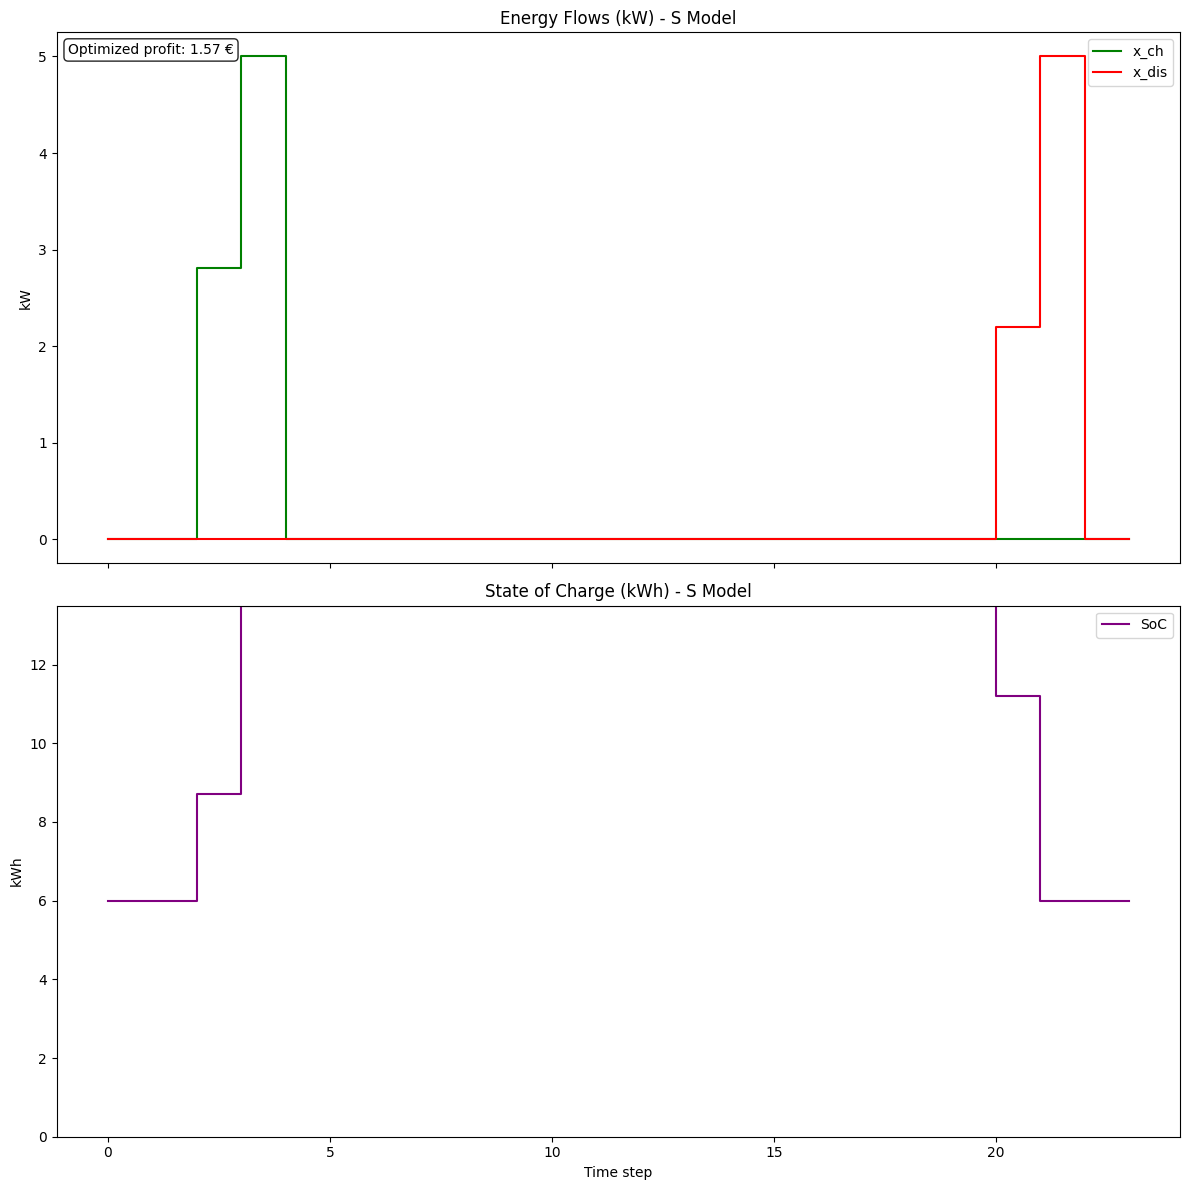

In [21]:
# -----------------------------------------------------------
# UNIFIED VISUALIZATION TOOLKIT
# -----------------------------------------------------------


# Helper: Annotate a plot with a text box (e.g., profits or messages)
def _annotate(ax, lines):
    ax.text(
        0.01, 0.98, "\n".join(lines),
        transform=ax.transAxes,
        va="top", ha="left",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.85),
        fontsize=10,
    )


# -----------------------------------------------------------
# MAIN WRAPPER FUNCTION
# -----------------------------------------------------------
def plot_results(modelVariant, m, v,
                 load, pv, imp, exp,
                 dt_h, T,
                 E_max_kwh):

    # =======================================================
    # 1. Compute baseline
    # =======================================================
    base_profit, P_imp0, P_exp0 = build_lg(
        load_kw=load, pv_kw=pv,
        import_price=imp, export_price=exp,
        dt_h=dt_h
    )

    # =======================================================
    # LG model
    # =======================================================
    if modelVariant == "LG":
        # Put baseline import and export series into a DataFrame for plotting
        df0 = pd.DataFrame({
            "t": np.arange(T),
            "P_imp0_kW": P_imp0,
            "P_exp0_kW": P_exp0,
        })

        fig, ax = plt.subplots(figsize=(10, 4))
        df0.plot(
            x="t",
            y=["P_imp0_kW", "P_exp0_kW"],
            ax=ax,
            drawstyle="steps-post",
            title="Baseline: Grid Imports/Exports (kW)",
            color=["blue", "orange"]
        )
        ax.set_xlabel("Time step")
        ax.set_ylabel("kW")
        _annotate(ax, [f"Baseline profit: {base_profit:.2f} €"])

        plt.tight_layout()
        plt.show()
        return  

    # =======================================================
    # Optimized Models (S or LGS)
    # =======================================================
    # An infeasible model will have no solution values to extract which throws an error. Therefore we check the model status first.
    if m.Status == GRB.INFEASIBLE:
        print("Model infeasible — no visualization possible.")
        return

    # -------------------------------------------------------
    # 2. Extract solution values from the Gurobi model
    # -------------------------------------------------------
    # We now build a small "results table" (pandas DataFrame) from the
    # Gurobi decision variables. This makes plotting and analysis easier.
    #
    # We start with a time index t = 0, 1, ..., T-1, and then add columns
    # for each variable that exists in the current model variant.
    #
    # Note that v is a Python dictionary of Gurobi variables (as returned from the model building functions),
    # e.g. v["x_ch"][t] is the Gurobi variable for x_ch at time t.
    # To get the numerical value, we use the ".X" attribute.

    data = {"t": np.arange(T)}  # time column

    # We loop over all potential variable names and check if the
    # corresponding entry exists in v for this model variant.
    for name in ["x_ch", "x_dis", "P_imp", "P_exp", "SoC"]:
        if name in v:
            # For each time step t, extract the solution value of v and collect them in a Python list.
            data[name] = [v[name][t].X for t in range(T)]

    # Create a pandas DataFrame from the collected data.
    # Each column corresponds to a time series (e.g. x_ch, SoC, P_imp, ...).
    df = pd.DataFrame(data)

    # The objective value of the optimized model is stored in m.ObjVal.
    # This is the total profit (including degradation cost for the LGS model).
    opt_profit = m.ObjVal

    # -------------------------------------------------------
    # 3. Build a multi-panel figure
    # -------------------------------------------------------
    n_rows = 3 if modelVariant == "LGS" else 2
    fig, axes = plt.subplots(
        n_rows, 1,
        figsize=(12, 12),
        sharex=True
    )

    # -------------------------------------------------------
    # Panel 1 — Flows (charge/discharge/import/export)
    # -------------------------------------------------------
    ax = axes[0]
    flow_cols = [c for c in ["x_ch", "x_dis", "P_imp", "P_exp"] if c in df.columns]
    flow_colors = {
        "x_ch": "green",
        "x_dis": "red",
        "P_imp": "blue",
        "P_exp": "orange",
    }

    if flow_cols:
        df.plot(
            x="t",
            y=flow_cols,
            ax=ax,
            drawstyle="steps-post",
            color=[flow_colors[c] for c in flow_cols],
            title=f"Energy Flows (kW) - {modelVariant} Model"
        )
        ax.set_ylabel("kW")
        _annotate(ax, [f"Optimized profit: {opt_profit:.2f} €"])

    # -------------------------------------------------------
    # Panel 2 — State of Charge
    # -------------------------------------------------------
    ax = axes[1]
    if "SoC" in df.columns:
        df.plot(
            x="t",
            y=["SoC"],
            ax=ax,
            color=["purple"],
            drawstyle="steps-post",
            title=f"State of Charge (kWh) - {modelVariant} Model"
        )
        ax.set_ylim(0, E_max_kwh)
        ax.set_ylabel("kWh")

    # -------------------------------------------------------
    # Panel 3 — Baseline import/export (only for BTM model)
    # -------------------------------------------------------
    if modelVariant == "LGS":
        df0 = pd.DataFrame({
            "t": np.arange(T),
            "P_imp0": P_imp0,
            "P_exp0": P_exp0,
        })

        ax = axes[2]
        df0.plot(
            x="t",
            y=["P_imp0", "P_exp0"],
            ax=ax,
            drawstyle="steps-post",
            color=["blue", "orange"],
            title=f"Energy Flows (kW) - {'LG'} Model"
        )
        ax.set_ylabel("kW")
        _annotate(ax, [f"Baseline profit: {base_profit:.2f} €"])

    # Final layout: set x-label only on the last row and tighten spacing
    axes[-1].set_xlabel("Time step")
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------
# CALL THE VISUALIZATION TOOL
# -----------------------------------------------------------

plot_results(
    modelVariant=modelVariant,
    m=m if modelVariant in ("S", "LGS") else None,
    v=v if modelVariant in ("S", "LGS") else None,
    load=load, pv=pv,
    imp=imp, exp=exp,
    dt_h=dt_h, T=T,
    E_max_kwh=E_max_kwh
)
